2018 Edition

# Challenge: What is the future selling price of a home?

A home is often the largest and most expensive purchase a person makes in his or her lifetime. Ensuring homeowners have a trusted way to monitor this asset is incredibly important.

In this competition, students are required to develop a full-fledged approach to make predictions about the future sale prices of homes. A full-fledged approach constist, at least, in the following steps:

* Descriptive statistics about the data
* Data cleaning and pre-processing
* Defining a modeling approach to the problem
* Build such a statistical model
* Validate the outcome of the model

Now, should you ask a home buyer to describe their dream house, they probably wouldn't begin with describing features such as the height of the basement ceiling or the proximity to a railroad. As you will see, the dataset we use in this competition proves that many more features influence price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in a small city in the US, this competition challenges you to predict the final price of each home.

# Our Notebook

### Textbook material
* “An Introduction to Statistical Learning”, by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani
https://link.springer.com/content/pdf/10.1007/978-1-4614-7138-7.pdf
 * Chapter 2, Chapter 3, “Linear Models”
 * Chapter 8, “Tree-based Methods”

### Advanced readings
* “An Introduction to Statistical Learning”, by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani
 * Chapter 9, “Support Vector Machines”
* “Gradient Boosting”, WikiPedia
https://en.wikipedia.org/wiki/Gradient_boosting
* “XGBoost: A Scalable Tree Boosting System”, https://arxiv.org/abs/1603.02754
* A video tutorial on XGBoost,
https://campus.datacamp.com/courses/extreme-gradient-boosting-with-xgboost/

### Imports

In [1]:
import os
import sys
import re
import random
import math
import scipy
import numpy as np
import pandas as pd
from time import time

#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as pat
from matplotlib.animation import FuncAnimation
import matplotlib.colors as colors
import matplotlib.cm as cm

#from pyspark import SparkContext
#from pyspark.sql import SQLContext
#from pyspark.sql.types import *
#from pyspark.sql import Row
#from pyspark.sql.functions import *

#from statsmodels.nonparametric.kernel_density import KDEMultivariate
#from statsmodels.nonparametric.kde import KDEUnivariate

#sqlContext = SQLContext(sc)

challenge_data_folder = "./challenge_data"

from datetime import datetime
from datetime import timedelta
from itertools import islice
#import statsmodels.api as sm

from IPython.display import HTML
#Map widget
install = !pip install ipyleaflet
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON, DrawControl, LayerGroup, basemaps
)
install = !pip install geocoder
install =!apt-get install ImageMagick
import geocoder

# !apt-get install ImageMagick #Package to convert images to gif

### Descriptive statistics about the data

In [2]:
pdAllData = pd.read_csv(challenge_data_folder+"/train.csv",keep_default_na=False) #Load training data keep_default_na FALSE to keep "Not available" data as they transport information
columnTypesDict = pdAllData.dtypes.to_dict() #Infer part of the data schema
columnNames = list(columnTypesDict.keys()) #List of all features name

In [115]:
pdAllData.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


In [4]:
print("Bedroom" in columnNames) #present in data description but not in training data
print("Kitchen" in columnNames)

False
False


In [3]:
pathDescr = (challenge_data_folder+"/Data description.rtf")
txtDescripData = open(pathDescr).readlines()

In [4]:
columnValues={}
columnIndex=[]
nbHeader = 7
NoHeaderTxtDescripData = txtDescripData[nbHeader:]
for feature in columnNames:
    if feature == 'Id': continue
    for index,line in enumerate(NoHeaderTxtDescripData):
        if feature in line:
            if(line.split(feature)[0]=='' and line.split(feature)[1][0]==':' ): #Make sure exactly this feature in this line 
                columnIndex.append((feature,index))
            pass

In [5]:
NoSpecificValfeatures = []
SpecificVal = {} #Will contain as keys column names and values the specified values in the description file

for index,featureLine in enumerate(columnIndex):
    
    startLine= featureLine[1]+2
    if index == len(columnIndex)-1: endLine = len(NoHeaderTxtDescripData)-1
    else: endLine = columnIndex[index+1][1]-1
    values = []
    if endLine <= startLine: #No specified value in the description file
        if featureLine[0]=='Heating': print(columnIndex[index])
        NoSpecificValfeatures.append(featureLine[0])
        continue
    for i in range(startLine,endLine):
        line = NoHeaderTxtDescripData[i] 
        values.append(line.split('\t')[0].strip())
    SpecificVal[featureLine[0]]=values
    
print(SpecificVal)

{'MSSubClass': ['20', '30', '40', '45', '50', '60', '70', '75', '80', '85', '90', '120', '150', '160', '180', '190'], 'MSZoning': ['A', 'C', 'FV', 'I', 'RH', 'RL', 'RP', 'RM'], 'Street': ['Grvl', 'Pave'], 'Alley': ['Grvl', 'Pave', 'NA'], 'LotShape': ['Reg', 'IR1', 'IR2', 'IR3'], 'LandContour': ['Lvl', 'Bnk', 'HLS', 'Low'], 'Utilities': ['AllPub', 'NoSewr', 'NoSeWa', 'ELO'], 'LotConfig': ['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3'], 'LandSlope': ['Gtl', 'Mod', 'Sev'], 'Neighborhood': ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NoRidge', 'NPkVill', 'NridgHt', 'NWAmes', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker'], 'Condition1': ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe'], 'Condition2': ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe'], 'BldgType': ['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'TwnhsI'],

In [18]:
NoSpecificValfeatures

['FullBath',
 'LowQualFinSF',
 'Utilities',
 'YearBuilt',
 'GarageCars',
 'MiscVal',
 '3SsnPorch',
 'BedroomAbvGr',
 'Condition1',
 'GarageType',
 'BsmtFinSF1',
 'YrSold',
 'MoSold',
 'BsmtUnfSF',
 'EnclosedPorch',
 'HalfBath',
 'LandContour',
 'PoolQC',
 'GrLivArea',
 'GarageQual',
 'Heating',
 'MasVnrArea',
 'OpenPorchSF',
 'WoodDeckSF',
 '1stFlrSF',
 'Fence',
 'BsmtQual',
 'GarageFinish',
 'PoolArea',
 'TotRmsAbvGrd',
 'ScreenPorch',
 'PavedDrive',
 'Fireplaces',
 'Functional',
 'SaleCondition',
 'MiscFeature',
 'FireplaceQu',
 'BsmtFinType2',
 'SaleType',
 'KitchenAbvGr',
 'GarageArea']

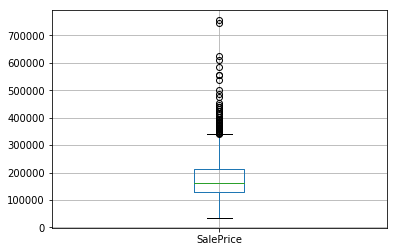

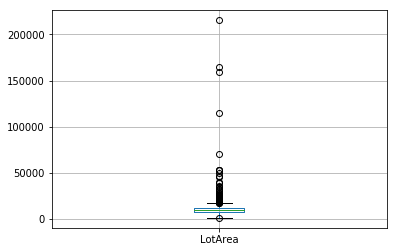

In [9]:
pdAllData.boxplot(column=["SalePrice"])
plt.show()
pdAllData.boxplot(column=["LotArea"])
plt.show()

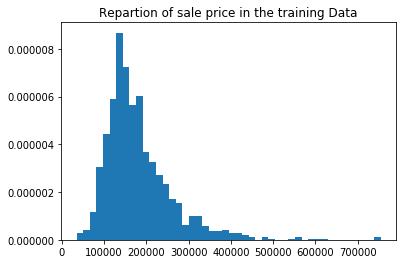

Number of unvalid sample with a sale price <= 0: 0


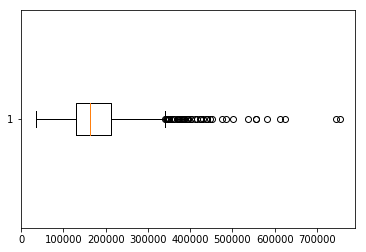

In [10]:
salePrices = pdAllData.SalePrice.tolist()
plt.hist(salePrices, bins='auto', density=True, cumulative=False)
plt.title("Repartion of sale price in the training Data")

plt.show()
print("Number of unvalid sample with a sale price <= 0:",pdAllData.SalePrice[pdAllData.SalePrice<=0].count())

plt.boxplot(salePrices, vert=False)
plt.show()

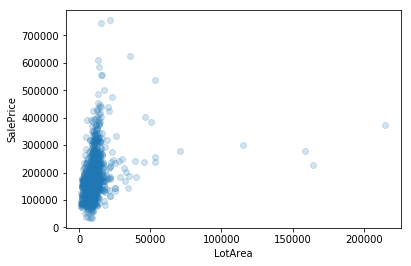

In [11]:
plt.scatter(pdAllData.LotArea, pdAllData.SalePrice, alpha=0.2)
plt.xlabel("LotArea")
plt.ylabel("SalePrice")
plt.show()

In [12]:
pdAllData[pdAllData.MSZoning == 'RL'].Id.count()

946

A : 0
C : 0
FV : 55
I : 0
RH : 12
RL : 946
RP : 0
RM : 178


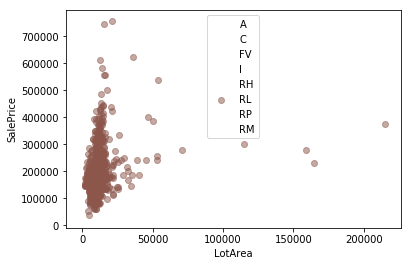

In [13]:
value='RL'

for MSZoningValue in SpecificVal['MSZoning']:
    pdAllData_MSZoningValue = pdAllData[pdAllData.MSZoning == MSZoningValue]
    print(MSZoningValue,':',pdAllData[pdAllData.MSZoning == MSZoningValue].Id.count())
    
    if MSZoningValue==value: alpha = 0.5
    else: alpha = 0
        
    plt.scatter(pdAllData_MSZoningValue.LotArea, pdAllData_MSZoningValue.SalePrice, alpha=alpha, label=MSZoningValue)
plt.xlabel("LotArea")
plt.ylabel("SalePrice")
plt.legend()
plt.show()

#matplotlib.animation avec une update function


KeyboardInterrupt: 

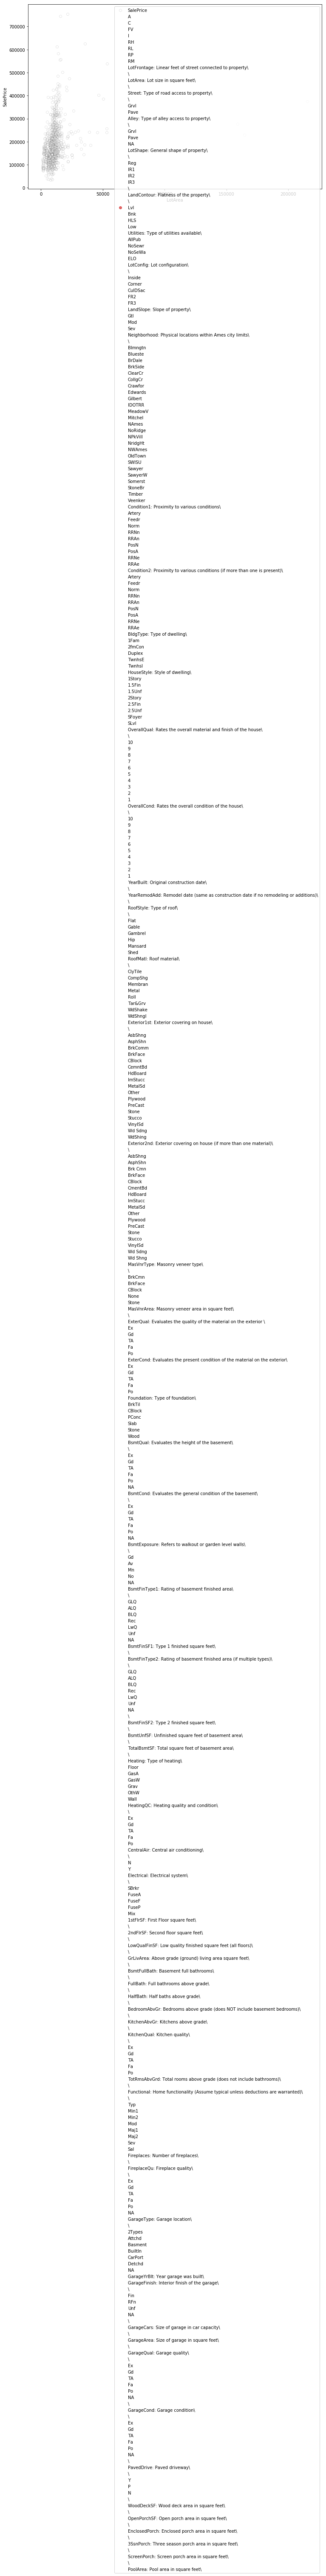

In [19]:
#import seaborn as sns
#sns.set()
#sns.set_style({'legend.frameon':True})
for specVal in SpecificVal['MSZoning']:
    plt.figure(figsize=(12,8))
    plt.subplots_adjust(left = .1)
    plt.scatter(pdAllData.LotArea,pdAllData.SalePrice,linewidth=0.5,facecolor='w',alpha =0.2,edgecolor='k')
    for MSZoningValue in SpecificVal['MSZoning']:
        pdAllData_MSZoningValue = pdAllData[pdAllData.MSZoning == MSZoningValue]
        
        if MSZoningValue==specVal: alpha = 0.7
        else: alpha = 0
            
        plt.scatter(pdAllData_MSZoningValue.LotArea, pdAllData_MSZoningValue.SalePrice, alpha=alpha, label=MSZoningValue)
        
    plt.xlabel("LotArea")
    ylbl = plt.ylabel("SalePrice")
    lgd = plt.legend()
    filename='temp/step'+str(specVal)+'.png'
    plt.savefig(filename)
    plt.clf()
    plt.close()
    #plt.gca()
!rm temp/*.gif
!convert -delay 100 temp/*.png temp/animated_scatter.gif
!rm temp/*.png
print("OK")

In [ ]:
HTML('<img src="temp/animated_scatter.gif">') # style="width:700px;height:500px">')

### Sale Price versus Area Price

In [16]:
#Neighborhood 89
#NextCategory 117

dicStreetName = {} # Abbreviation : Street name
dicStreetLoc = {} # Abbreviation : location returned by geocoder
for index in range(92,117):
    line = txtDescripData[index]
    line = line.strip()
    line = line.split('\t')
    dicStreetName[line[0]]= line[1][:-1]
    dicStreetLoc[line[0]] = geocoder.google(line[1][:-1]+', Ames')

In [17]:

def calcAreasPrices(pdDF):
    """
    Returns dictionnaire = {"Neigborhood":areaPrice}
    
    """
    dicStreetPriceAreas={}
    def calcAreaPrice(row):
        neighborhood = row.Neighborhood
        try:
            dicStreetPriceAreas[neighborhood] #see if already defined
        except KeyError:
            dicStreetPriceAreas[neighborhood]=[0,0,0]
        dicStreetPriceAreas[neighborhood][0]+=row.SalePrice
        dicStreetPriceAreas[neighborhood][1]+=row.LotArea
    none = pdDF.apply(calcAreaPrice,axis=1) #fill the dictionnary
    for place in dicStreetPriceAreas:
        areaPrice = dicStreetPriceAreas[place][0]/dicStreetPriceAreas[place][1]
        dicStreetPriceAreas[place] = areaPrice
    return dicStreetPriceAreas
    #print(dicStreetPriceAreas[neighborhood])
dicStreetPriceAreas = calcAreasPrices(pdAllData)
print(dicStreetPriceAreas)

{'CollgCr': 20.43893739265472, 'Veenker': 15.133918143832238, 'Crawfor': 16.92658934743337, 'NoRidge': 23.049928679388874, 'Mitchel': 14.23237526116939, 'Somerst': 29.55322320949371, 'NWAmes': 16.49992834611817, 'OldTown': 15.708946967813892, 'BrkSide': 16.910100475938656, 'Sawyer': 13.4242253219904, 'NridgHt': 28.8899788413152, 'NAmes': 14.189682044633944, 'SawyerW': 19.38387882154937, 'IDOTRR': 12.054208428802571, 'MeadowV': 41.25743415463042, 'Edwards': 12.843999136512851, 'Timber': 9.50119128123673, 'Gilbert': 17.19430711971769, 'StoneBr': 29.490541930638102, 'ClearCr': 6.732846177897465, 'NPkVill': 49.569387355646896, 'Blmngtn': 57.70382718760606, 'BrDale': 59.280813815945116, 'SWISU': 17.504403242359622, 'Blueste': 84.61538461538461}


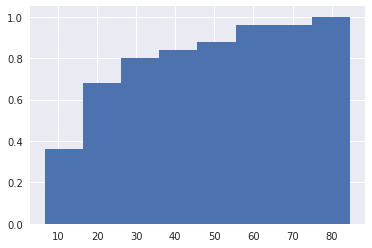

In [18]:
areaPrices = calcAreasPrices(pdAllData).values()
hist = plt.hist(areaPrices,cumulative=True,normed=True, bins='auto')
plt.show()

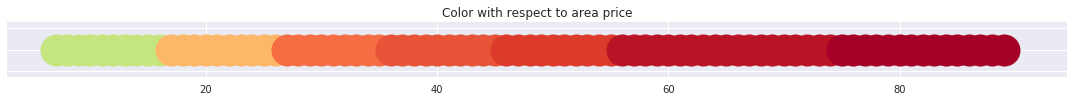

Area Price around Ames


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [19]:
markersList = []
for place in dicStreetPriceAreas:
    coordGeo = dicStreetLoc[place]
    areaPrice = dicStreetPriceAreas[place]
    try:
        lastLowerValuesIndex = list(map(lambda x: x <= areaPrice,hist[1])).index(False)-1
    except ValueError:
        lastLowerValuesIndex = len(hist[0])-1
    #print(lastLowerValuesIndex)
    colorfloat = hist[0][lastLowerValuesIndex] #Use the cumulative hist to get the color
    #colorfloat = (-minAreaPrice)/(maxAreaPrice-minAreaPrice)

    #print(dicStreetPirceArea[place][2],colorfloat)
    markerColor = colors.rgb2hex(cmapRdYlGn(1-colorfloat))#green to red
    marker = CircleMarker(location=(coordGeo.lat, coordGeo.lng), radius=10, color=markerColor, fill_color=markerColor)
    markersList.append(marker)

g = geocoder.google('Ames')
m = Map(center=[g.lat, g.lng], zoom=11)

markersList = [x for x in markersList if x!=None]
group = LayerGroup(layers=markersList)

#PLot color bar
fig,ax = fig, ax = plt.subplots(figsize=(19,1))
plt.title("Color with respect to area price")
minPriceArea,maxPriceArea = 7,90
for areaPrice in np.arange(minPriceArea,maxPriceArea,1):
    try:
        lastLowerValuesIndex = list(map(lambda x: x<= areaPrice,hist[1])).index(False)-1
    except ValueError:
        lastLowerValuesIndex = len(hist[0])-1
    #print(lastLowerValuesIndex)
    colorfloat = hist[0][lastLowerValuesIndex] #Use the cumulative hist to get the color
    plt.scatter(areaPrice,0,c = cmapRdYlGn(1-colorfloat),s=1000)
plt.setp( ax.get_yticklabels(), visible=False)
ax.yaxis.set_ticks_position('none') 
plt.show()

m.add_layer(group)
print("Area Price around Ames")
m



## Data cleaning and pre-processing

In [20]:
pathBadDescr = (challenge_data_folder+"/Bad_Description.rtf")
txtBadDescripData = open(pathBadDescr).readlines()

In [21]:
#Cleaning the data with original data description file:

columnValuesBad={}
columnIndexBad=[]
nbHeader = 7
NoHeaderTxtBadDescripData = txtBadDescripData[nbHeader:]
for feature in columnNames:
    if feature == 'Id': continue
    for index,line in enumerate(NoHeaderTxtBadDescripData):
        if feature in line:
            if(line.split(feature)[0]=='') :
                columnIndexBad.append((feature,index))
            pass
NoSpecificValfeaturesBad = []
SpecificValBad = {} #Will contain as keys column names and values the specified values in the description file

for index,featureLine in enumerate(columnIndexBad):
    startLine= featureLine[1]+2
    if index == len(columnIndexBad)-1: endLine = len(NoHeaderTxtBadDescripData)-1
    else: endLine = columnIndexBad[index+1][1]-1
    values = []
    if endLine <= startLine: #No specified value in the description file
        NoSpecificValfeaturesBad.append(featureLine[0])
        continue
    for i in range(startLine,endLine):
        line = NoHeaderTxtBadDescripData[i] 
        values.append(line.split('\t')[0].strip())
    SpecificValBad[featureLine[0]]=values
    
dicBadValuesBad = []
for factor in SpecificValBad:
    #For a factor search for any value not specified in the description file 
    
    typeCol = columnTypesDict[factor]
    if typeCol == 'int64': valSpec = [int(i) for i in SpecificValBad[factor]]
    else: valSpec = SpecificValBad[factor]
    pdInter = pdAllData.apply(lambda x: x[factor] not in valSpec,axis=1)
    potentialBadValues = pdAllData[pdAllData.apply(lambda x: x[factor] not in valSpec,axis=1)]
    nbBadVal = len(potentialBadValues)
    if nbBadVal>0:
        badValues = [factor]
        badValues.append(potentialBadValues.groupby(factor)[factor].count().to_dict())
        dicBadValuesBad.append(badValues)
dicBadValuesBad


ValueError: invalid literal for int() with base 10: 'RoofStyle: Type of roof\\'

Errors: <br>
Bedroom instead of BedroomAbvGr<br>
Kitchen instead of KitchenAbvGr<br>

In [106]:
#Cleaning the data with fixed description file

#Retrieve Bad values  for the columns with specified values
dicBadValues = []
for factor in SpecificVal:
    
    #For a factor search for any value not specified in the description file 
    #In terms of type of valu
    
    typeCol = columnTypesDict[factor]
    if typeCol == 'int64': valSpec = [int(i) for i in SpecificVal[factor]]
    else: valSpec = SpecificVal[factor]
    pdInter = pdAllData.apply(lambda x: x[factor] not in valSpec,axis=1)
    potentialBadValues = pdAllData[pdAllData.apply(lambda x: x[factor] not in valSpec,axis=1)]
    nbBadVal = len(potentialBadValues)
    
    if nbBadVal>0:
        badValues = [factor]
        badValues.append(potentialBadValues.groupby(factor)[factor].count().to_dict())
        dicBadValues.append(badValues)
dicBadValues

[['MSZoning', {'C (all)': 9}],
 ['BldgType', {'Twnhs': 37}],
 ['MasVnrType', {'NA': 6}]]

In [107]:
#Retrieve Bad values for the columns with not specified values such as year of construction of 

for feature in NoSpecificValfeatures:
    dtypeColumn = columnTypesDict[feature]
    if dtypeColumn=='float64': typeFun = float
    elif dtypeColumn=='int64': typeFun = int
    pdInter = pdAllData[pdAllData.apply(lambda x: x[feature]=='NA',axis=1)]
    if len(pdInter)>0:
        badValues=[feature]
        badValues.append(pdInter.groupby(feature)[feature].count().to_dict())
        dicBadValues.append(badValues)
dicBadValues

[['MSZoning', {'C (all)': 9}],
 ['BldgType', {'Twnhs': 37}],
 ['MasVnrType', {'NA': 6}],
 ['LotFrontage', {'NA': 210}],
 ['MasVnrArea', {'NA': 6}],
 ['GarageYrBlt', {'NA': 67}]]

In [24]:
print('When GarageYrBlt = NA, GarageYearType has values ',set(pdAllData[pdAllData.apply(lambda x: x.GarageYrBlt=='NA',axis=1)].GarageType.values))
print('When MasVnrArea = NA, MasVnrArea has values',set(pdAllData[pdAllData.apply(lambda x: x.MasVnrArea=='NA',axis=1)].MasVnrType.values))

When GarageYrBlt = NA, GarageYearType has values  {'NA'}
When MasVnrArea = NA, MasVnrArea has values {'NA'}


# Comment
<div class='alert alert-warning'>
Fixed some errors but some persist <br>
<li>C(all)</li>
<li>Twnhs</li>
Have no direct typo or wrintings<br>
Otherwise the other NA values can be explained by other specified values. The two cases above state that when a property has no garage, the year the garage has been built is not available and no MasVnrType implies no MasVnrArea which is reasonable but important to take into account.<br>


</div>

In [25]:
print(dicStreetPriceAreas)

{'CollgCr': 20.43893739265472, 'Veenker': 15.133918143832238, 'Crawfor': 16.92658934743337, 'NoRidge': 23.049928679388874, 'Mitchel': 14.23237526116939, 'Somerst': 29.55322320949371, 'NWAmes': 16.49992834611817, 'OldTown': 15.708946967813892, 'BrkSide': 16.910100475938656, 'Sawyer': 13.4242253219904, 'NridgHt': 28.8899788413152, 'NAmes': 14.189682044633944, 'SawyerW': 19.38387882154937, 'IDOTRR': 12.054208428802571, 'MeadowV': 41.25743415463042, 'Edwards': 12.843999136512851, 'Timber': 9.50119128123673, 'Gilbert': 17.19430711971769, 'StoneBr': 29.490541930638102, 'ClearCr': 6.732846177897465, 'NPkVill': 49.569387355646896, 'Blmngtn': 57.70382718760606, 'BrDale': 59.280813815945116, 'SWISU': 17.504403242359622, 'Blueste': 84.61538461538461}


In [26]:
pdTData = pd.read_csv(challenge_data_folder+"/train.csv")

In [27]:
pdTData.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1200.000000,1200.000000,990.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1194.000000,1200.000000,...,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,600.500000,57.075000,70.086869,10559.411667,6.105000,5.568333,1971.350833,1984.987500,103.962312,444.886667,...,95.136667,46.016667,22.178333,3.653333,14.980833,1.909167,40.453333,6.311667,2007.810833,181414.628333
std,346.554469,42.682012,23.702029,10619.135549,1.383439,1.120138,30.048408,20.527221,183.534953,439.987844,...,124.034129,65.677629,61.507323,29.991099,54.768057,33.148327,482.323444,2.673104,1.319027,81070.908544
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1875.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,300.750000,20.000000,59.000000,7560.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129900.000000
50%,600.500000,50.000000,70.000000,9434.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,385.500000,...,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163700.000000
75%,900.250000,70.000000,80.000000,11616.000000,7.000000,6.000000,2000.000000,2004.000000,166.750000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1200.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2260.000000,...,857.000000,523.000000,552.000000,508.000000,410.000000,648.000000,15500.000000,12.000000,2010.000000,755000.000000


In [104]:
pdTData['Neighborhood'].value_counts()

NAmes      179
CollgCr    120
OldTown     95
Edwards     81
Somerst     68
NridgHt     68
Gilbert     67
Sawyer      66
NWAmes      55
SawyerW     51
BrkSide     45
Mitchel     41
Crawfor     40
IDOTRR      33
NoRidge     32
Timber      30
ClearCr     25
StoneBr     23
SWISU       20
MeadowV     15
Blmngtn     15
BrDale      12
Veenker     10
NPkVill      7
Blueste      2
Name: Neighborhood, dtype: int64

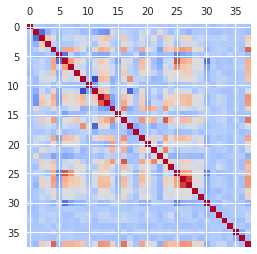

In [29]:
pdTData.cov()
plt.matshow(pdTData.corr(),cmap=plt.cm.coolwarm)

## Defining a modeling approach to the problem

### Random model
Get the price by a random choice. The distribution of prices is lognormal.

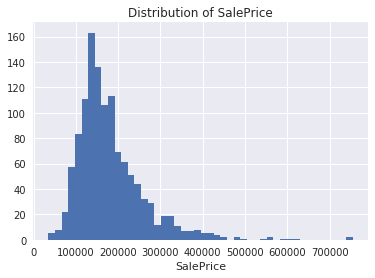

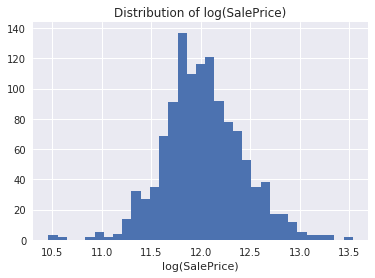

In [162]:
plt.hist(pdAllData.SalePrice, bins='auto')
plt.xlabel("SalePrice")
plt.title("Distribution of SalePrice")
plt.show()

plt.hist(np.log(pdAllData.SalePrice), bins='auto')
plt.xlabel("log(SalePrice)")
plt.title("Distribution of log(SalePrice)")
plt.show()

In [157]:
logRMSEsRand = []

for i in range(10000):
    #get validation and train data randomly
    pdTrainData, pdValidationData = getTrainValidationData(pdAllData, ratioValidation=0.1)

    #Get the mean and the standard deviation
    meanLogSalePrice = np.log(pdTrainData.SalePrice).mean()
    stdLogSalePrice = np.log(pdTrainData.SalePrice).std()

    #Generate the log of prices randomly with a gaussian approximation
    randomLogSalePrices = np.random.normal(meanLogSalePrice, stdLogSalePrice, len(pdValidationData))
    randomSalePrices = np.exp(randomLogSalePrices)
    pdRandomSalePrices = pd.Series(randomSalePrices)

    #retrieve the error logRMSE
    logRMSEsRand.append(getLogRMSE(pdRandomSalePrices, pdValidationData.SalePrice))
    
print("Mean of LogRMSEs of a totally random model:", np.mean(logRMSEs))

Mean of LogRMSEs of a totally random model: 0.552102270157586


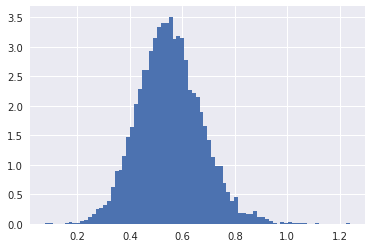

In [161]:
plt.hist(logRMSEsRand, normed=True, bins='auto')
plt.show()

### A very simple model

The first step is to begin with a really simple model, in order to have first results and write functions to retrieve the data and write the results in the right format. The goal is also to write functions to evaluate the results and test it.
<br>
The first model we will do doesn't take care of "NaN" (=unknown) values because we will only use the lotArea and the neighborhood.
<br>
The idea is to retrieve the mean price per $m^2$ for each neighborhood, and then calculate the price thanks to the lotArea.

In [12]:
def getTrainValidationData(dataframe, ratioValidation=0.1, numberValidation = None):
    """
    Random splitting into train and validation data, according to the ratio or the number given.
    
    trainData, validationData = getTrainValidationData(dataframe, ratioValidation=0.1)
    """
    if numberValidation == None : numberValidation = int(ratioValidation*len(dataframe))
    if numberValidation > len(dataframe) : numberValidation = len(dataframe)
    if ratioValidation > 1 : ratioValidation = 1
    if ratioValidation < 0 : rationValidation = 0
        
    nbSamples = len(dataframe)
    
    indicesValidation = np.random.choice(nbSamples, numberValidation, replace=False)
    indicesTrain = np.setdiff1d(np.arange(nbSamples), indicesValidation)
    
    return dataframe.iloc[indicesTrain], dataframe.iloc[indicesValidation]

In [4]:
def getLogRMSE(estimatedPrice,realPrice):
    logRMSE = np.mean( (np.log(estimatedPrice) - np.log(realPrice))**2 )
    return np.sqrt(logRMSE)

In [14]:
def simpleEstimationPrice(pdTrain,pdValidation):
    dictAreasPrices = calcAreasPrices(pdTrain)
    estimatedPrice = pdValidation.apply(lambda x:x['LotArea']*dictAreasPrices[x.Neighborhood],axis=1)
    realPrice = pdValidation.SalePrice
    logRMSE = getLogRMSE(estimatedPrice,realPrice)
    return estimatedPrice,logRMSE

In [20]:
ratioValidations = np.arange(0.01,0.26,0.01)
logRMSEs = []
for ratioValidation in ratioValidations:
    pdTrainData, pdValidationData = getTrainValidationData(pdAllData, ratioValidation=ratioValidation)
    estimatedPrice,logRMSE = simpleEstimationPrice(pdTrainData,pdValidationData)
    logRMSEs.append(logRMSE)

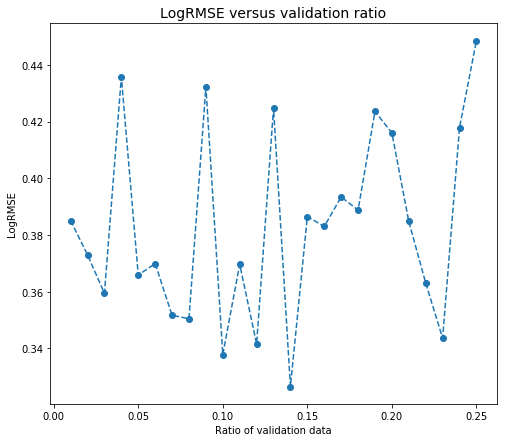

In [21]:
plt.figure(figsize=(8,7))
plt.title("LogRMSE versus validation ratio",fontsize=14)

plt.plot(ratioValidations,logRMSEs,'--o')
plt.ylabel("LogRMSE")
plt.xlabel("Ratio of validation data")
plt.show()

### Comments
<div class="alert alert-warning">
<ul>
<li> The error increases with the size of the validation data. Because more validation data means less training data.
<li> The very simple model gives not terrible results but has huge limitations. Indeed, if the model tries to estimate a good with a neighborhood different from all the ones in the training data, the model simply cannot predict its price. <br>

<h4>A COMPLETER<h4>
</ul>
</div>

In [186]:
logRMSEs = []
for i in range(10000):
    try: # "Bad" shuffle can lead to unseen neighborhood in the training data
        pdTrainData, pdValidationData = getTrainValidationData(pdAllData, ratioValidation=0.1)
        estimatedPrice,logRMSE = simpleEstimationPrice(pdTrainData,pdValidationData)
        logRMSEs.append(logRMSE)
    except:
        pass

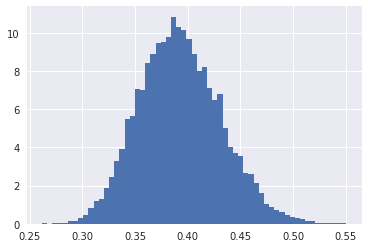

In [187]:
plt.hist(logRMSEs, normed=True,bins='auto')
plt.show()
plt.boxplot(logRMSEs)
plt.show()

In [78]:
ratioValidations = np.arange(0.05,0.31,0.05)
logRMSEs = []
logRMSEsMean = []
logRMSEsStd = []
for ratioValidation in ratioValidations:
    logRMSEsRatio = []
    for i in range(1000):
        try: # "Bad" shuffle can lead to unseen neighborhood in the training data
            pdTrainData, pdValidationData = getTrainValidationData(pdAllData, ratioValidation=ratioValidation)
            estimatedPrice,logRMSE = simpleEstimationPrice(pdTrainData,pdValidationData)
            logRMSEsRatio.append(logRMSE)
        except:
            pass
    logRMSEsMean.append(np.mean(logRMSEsRatio))
    logRMSEsStd.append(np.std(logRMSEsRatio))
    logRMSEs.append(logRMSEsRatio)
    #plt.hist(logRMSEsRatio, normed=True,bins='auto',alpha=0.2,label=str(ratioValidation))

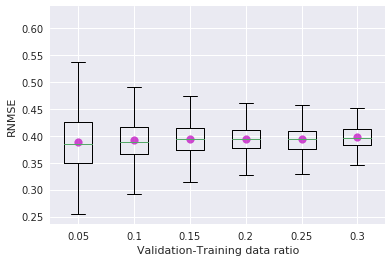

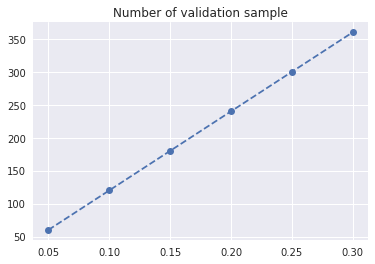

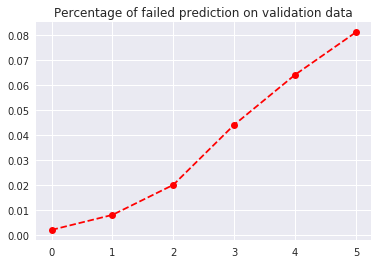

In [90]:
fig, ax = plt.subplots()
plt.scatter(range(1,len(ratioValidations)+1),logRMSEsMean,c='m',s=60,alpha=0.7)
plt.boxplot(logRMSEs)
plt.setp(ax,xticklabels=np.round(ratioValidations,2))
plt.xlabel('Validation-Training data ratio')
plt.ylabel('RNMSE')
plt.show()

plt.figure()
plt.plot(ratioValidations,np.round(ratioValidations*1200),'--o')
plt.title('Number of validation sample')
plt.show()

plt.figure()
plt.plot([(1000-len(x))/1000 for x in logRMSEs],'r--o')
plt.title('Percentage of failed prediction on validation data')
plt.show()

# Scikit learn trees

http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html To encode labels as num values 
http://pbpython.com/categorical-encoding.html Tuto to encode labels

## Preprocessing

In [45]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from mpl_toolkits.mplot3d import Axes3D
cmapRdYlGn = cm.get_cmap('RdYlGn')
cmap = cm.coolwarm

In [33]:
pdAllData = pd.read_csv(challenge_data_folder+"/train.csv",keep_default_na=False) #Load training data NA filter FALSE to keep Not available data

In [34]:
pdAllDataObj = pd.read_csv(challenge_data_folder+"/train.csv",keep_default_na=False)#= pdAllData.select_dtypes(include=['object']).copy() #Test

In [35]:
lb_make = LabelEncoder()

for featureCol in pdAllData:
    if pdAllData[featureCol].dtype=='object':
        pdAllData[featureCol] = lb_make.fit_transform(pdAllData[featureCol])
    else:
        continue
pdAllData.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,71,8450,1,1,3,3,0,...,0,3,4,1,0,2,2008,8,4,208500
1,2,20,3,86,9600,1,1,3,3,0,...,0,3,4,1,0,5,2007,8,4,181500
2,3,60,3,74,11250,1,1,0,3,0,...,0,3,4,1,0,9,2008,8,4,223500
3,4,70,3,66,9550,1,1,0,3,0,...,0,3,4,1,0,2,2006,8,0,140000
4,5,60,3,90,14260,1,1,0,3,0,...,0,3,4,1,0,12,2008,8,4,250000


In [36]:
X = pdAllData.drop(['Id','SalePrice'],axis=1)
Y = pdAllData.SalePrice

## Single Tree regressions

In [13]:
def singleTreeRegression(depth=6,min_samples_leaf=8,test_size=0.25):
    X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = test_size, random_state = 12345)# np.random.randint(0,100))
    regressor = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf,max_depth=depth)
    regressor.fit(X_train, y_train)
    y_hat_test = regressor.predict(X_test)
    training_estimation = regressor.predict(X_train)
    return getLogRMSE(y_hat_test,y_test) ,getLogRMSE(training_estimation,y_train) #test error train error

In [17]:
LogRMSEs =[]
LogRMSEsTraining =[]
depths = range(1,20)
nbTest = 20
for depth in depths:
    mean_test_error =0
    mean_train_error = 0
    for test in range(nbTest): #get mean error cope with random split
        test_error, train_error = singleTreeRegression(depth=depth,min_samples_leaf=1,test_size=0.25)
        mean_test_error += test_error
        mean_train_error +=train_error
    LogRMSEs.append(mean_test_error/nbTest)
    LogRMSEsTraining.append(mean_train_error/nbTest)

Depth to reach minimal test acurracy: 7


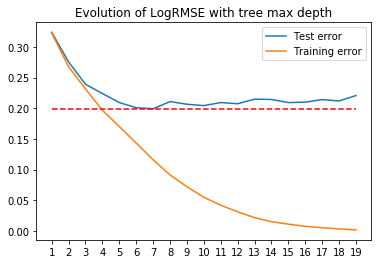

In [18]:
print('Depth to reach minimal test acurracy:',np.argmin(LogRMSEs)+1)
plt.plot(depths,LogRMSEs,label='Test error')
plt.plot(depths,LogRMSEsTraining,label='Training error')
plt.plot(depths,[np.min(LogRMSEs)]*len(depths),'r--')
plt.xticks(depths)
plt.title('Evolution of LogRMSE with tree max depth')
plt.legend()
plt.show()

In [24]:
LogRMSEs =[]
LogRMSEsTraining =[]
depth = 7 #from previous question
min_samples_leaf_list=range(1,40)
nbTest = 20
for min_samples_leaf in min_samples_leaf_list:
    mean_test_error =0
    mean_train_error = 0
    for test in range(nbTest): #get mean error cope with random split
        test_error, train_error = singleTreeRegression(depth=7,min_samples_leaf=min_samples_leaf,test_size=0.25)
        mean_test_error += test_error
        mean_train_error +=train_error
    LogRMSEs.append(mean_test_error/nbTest)
    LogRMSEsTraining.append(mean_train_error/nbTest)

min_samples_leaf to reach minimal test acurracy: 15


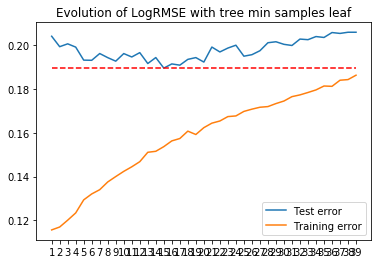

In [25]:
print('min_samples_leaf to reach minimal test acurracy:',np.argmin(LogRMSEs)+1)
plt.plot(min_samples_leaf_list,LogRMSEs,label='Test error')
plt.plot(min_samples_leaf_list,LogRMSEsTraining,label='Training error')
plt.plot(min_samples_leaf_list,[np.min(LogRMSEs)]*len(min_samples_leaf_list),'r--')
plt.xticks(min_samples_leaf_list)
plt.title('Evolution of LogRMSE with tree min samples leaf')
plt.legend()
plt.show()

## Grid 

In [37]:
depth_list = np.arange(1,21)
min_samples_leaf_list = np.arange(1,40)
depth_grid,min_samples_leaf_grid = np.meshgrid(depth_list,min_samples_leaf_list)

In [15]:
grid_result_test = np.zeros((len(depth_grid),len(depth_grid[0])))
grid_result_train = np.zeros((len(depth_grid),len(depth_grid[0])))
nbTest = 1
test_size = 0.25
for i in range(len(depth_grid)):
    for j in range(len(depth_grid[0])):
        for test in range(nbTest): #repeat test to get mean 
            depth = depth_grid[i,j]
            min_samples_leaf = min_samples_leaf_grid[i,j]
            test_error, train_error = singleTreeRegression(depth=depth,min_samples_leaf=min_samples_leaf,test_size=test_size)
            grid_result_test[i,j]+=test_error
            grid_result_train[i,j]+=train_error
        grid_result_test[i,j]=grid_result_test[i,j]/nbTest
        grid_result_train[i,j]=grid_result_train[i,j]/nbTest

min leaf nb,depth = 14 11 with error: 0.18543555623522728


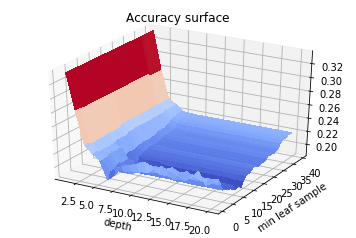

In [16]:
regularisation_coef = 0.005 #To get a less deep tree

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(depth_grid, min_samples_leaf_grid, grid_result_test,cmap=cm.coolwarm,linewidth=0, antialiased=False)
plt.title('Accuracy surface')
plt.xlabel('depth')
plt.ylabel('min leaf sample')
ind = np.unravel_index(np.argmin(grid_result_test, axis=None), grid_result_test.shape)
print('min leaf nb,depth =',ind[0]+1,ind[1]+1,'with error:',grid_result_test[ind])
plt.show()
#ind = np.unravel_index(np.argmin(grid_result_test+regularisation_coef*depth_grid, axis=None), grid_result_test.shape)
#print('min leaf nb,depth =',ind[0]+1,ind[1]+1,'with error:',grid_result_test[ind])


In [17]:
regularisation_coef_list = np.arange(0.001,0.1,0.001)
error_list = []
depth_list = []
min_leaf_list = []
error_no_reg = np.min(grid_result_test)
for reg_coef in regularisation_coef_list:
    ind = np.unravel_index(np.argmin(grid_result_test+reg_coef*depth_grid, axis=None), grid_result_test.shape)
    error = grid_result_test[ind]
    #print('min leaf nb,depth =',ind[0]+1,ind[1]+1,'with error:',error)
    error_list.append(error)
    depth_list.append(ind[1]+1)
    min_leaf_list.append(ind[0]+1)

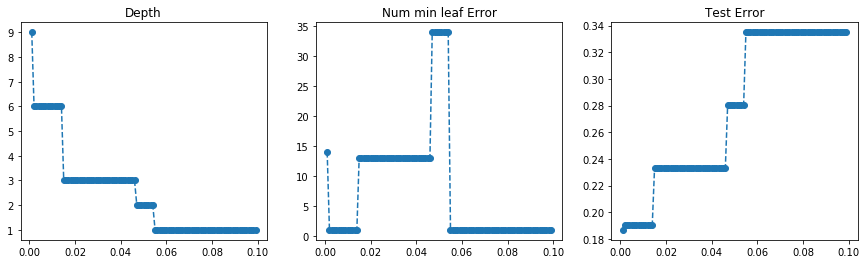

In [18]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.title('Depth')
plt.plot(regularisation_coef_list,depth_list,'--o')
plt.subplot(132)
plt.title('Num min leaf Error')
plt.plot(regularisation_coef_list,min_leaf_list,'--o')
plt.subplot(133)
plt.title('Test Error')
plt.plot(regularisation_coef_list,error_list,'--o')
plt.show()

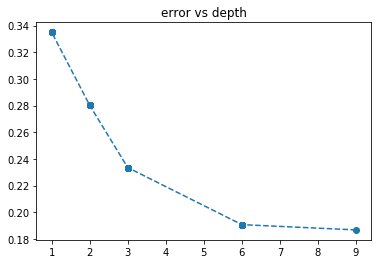

In [19]:
cmap = cm.coolwarm


plt.title('error vs depth')
plt.plot(depth_list,error_list,'--o')

max_depth = np.max(depth_list)
min_depth = np.min(depth_list)
max_error = np.max(error_list)
min_error = np.min(error_list)

#plt.hist((np.array(depth_list)-min_depth)/(max_depth-min_depth)**2+(np.array(depth_list)-max_error)/(max_error-min_error)**2)
plt.show()

In [20]:
depth = 3
first_ind_depth = depth_list.index(depth)
min_leaf = min_leaf_list[first_ind_depth]
print(min_leaf)

13


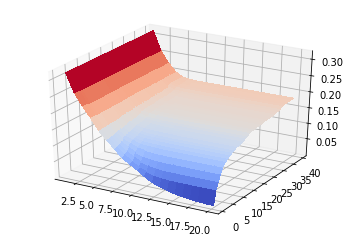

In [30]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(depth_grid, min_samples_leaf_grid, grid_result_train,cmap=cm.coolwarm,linewidth=0, antialiased=False)
plt.show()

In [35]:
depth = 3
min_samples_leaf = 13
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = test_size, random_state = 100)
regressor = DecisionTreeRegressor(max_depth=depth,min_samples_leaf=min_samples_leaf)
regressor.fit(X_train, y_train)
y_hat_test = regressor.predict(X_test)
traing_estimation = regressor.predict(X_train)
test_error = getLogRMSE(y_hat_test,y_test)
training_error = getLogRMSE(traing_estimation,y_train)
print(test_error)
export_graphviz(regressor, out_file='tree.dot', feature_names=columnNames[1:-1])
!dot -Tpng tree.dot > tree.png # to convert the tree in a png image

0.22923102929979267


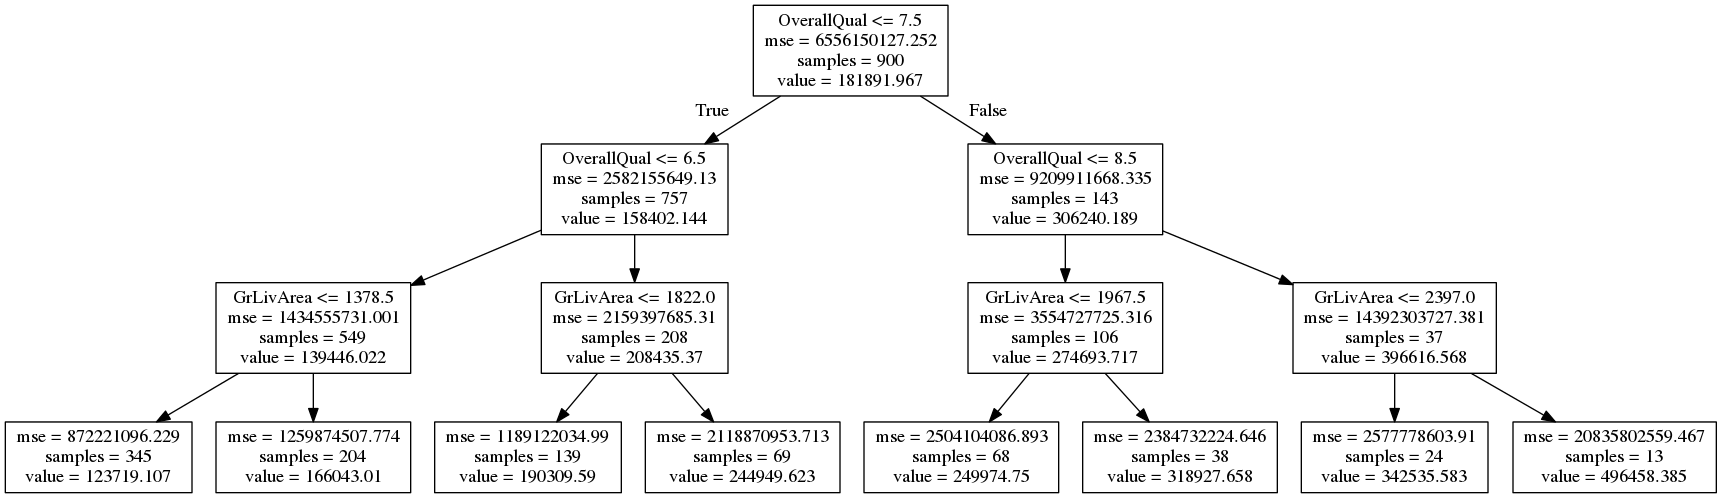

In [36]:
from IPython.display import Image
Image(filename='tree.png')

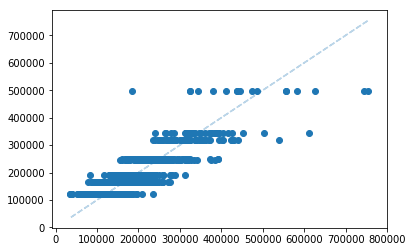

In [37]:
plt.plot(Y,Y,'--',alpha=0.3)
plt.scatter(Y,regressor.predict(X))
plt.show()

## Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
import time

In [27]:
def regressionTrees(X=X,Y=Y,depth=6,min_samples_leaf=8,test_size=0.25,singleTree=True,forest=False,extraTrees=False,nb_estimator=20):
    X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = test_size, random_state = 42)# np.random.randint(0,100))
    if singleTree: regressor = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf,max_depth=depth)
    elif forest: regressor = RandomForestRegressor(min_samples_leaf=min_samples_leaf,max_depth=depth,n_estimators=nb_estimator,random_state=42)#, max_depth=depth,min_samples_leaf=min_samples_leaf)
    elif extraTrees: regressor = ExtraTreesClassifier(min_samples_leaf=min_samples_leaf,max_depth=depth,n_estimators=nb_estimator,random_state=42)#, max_depth=depth,min_samples_leaf=min_samples_leaf)
    
    regressor.fit(X_train, y_train)
    y_hat_test = regressor.predict(X_test)
    training_estimation = regressor.predict(X_train)
    return getLogRMSE(y_hat_test,y_test) ,getLogRMSE(training_estimation,y_train) #test error train error

In [47]:
depth = 100
min_samples_leaf = 1
test_errors = []
train_errors = []

test_errors_extra = []
train_errors_extra = []

nb_estimators = range(1,100,2)
for nb_estimator in nb_estimators:
    
    test_error, train_error = regressionTrees(depth=depth,min_samples_leaf=min_samples_leaf,test_size=0.25,singleTree=False,forest=True,extraTrees=False,nb_estimator=nb_estimator)
    test_errors.append(test_error)
    train_errors.append(train_error)
    
    test_error, train_error = regressionTrees(depth=depth,min_samples_leaf=min_samples_leaf,test_size=0.25,singleTree=False,forest=False,extraTrees=True,nb_estimator=nb_estimator)
    test_errors_extra.append(test_error)
    train_errors_extra.append(train_error)

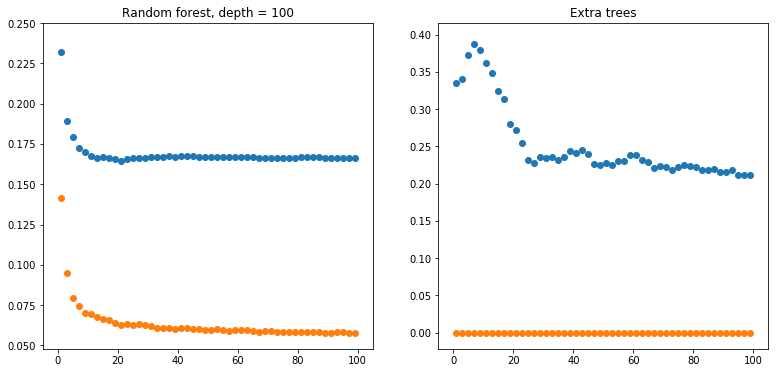

In [49]:
plt.figure(figsize=(13,6))
plt.subplot(121)
plt.title("Random forest, depth = "+str(depth))
plt.scatter(nb_estimators,test_errors)
plt.scatter(nb_estimators,train_errors)

plt.subplot(122)
plt.title("Extra trees")
plt.scatter(nb_estimators,test_errors_extra)
plt.scatter(nb_estimators,train_errors_extra)

plt.show()

In [34]:
depth_list = np.arange(1,21)
min_samples_leaf_list = np.arange(1,41)
depth_grid,min_samples_leaf_grid = np.meshgrid(depth_list,min_samples_leaf_list)

In [31]:
grid_result_test = np.zeros((len(depth_grid),len(depth_grid[0])))
grid_result_train = np.zeros((len(depth_grid),len(depth_grid[0])))
time_grid = np.zeros((len(depth_grid),len(depth_grid[0])))
nbTest = 1
test_size = 0.25

for i in range(len(depth_grid)):
    for j in range(len(depth_grid[0])):
        time_tests= time.time()
        for test in range(nbTest): #repeat test to get mean 
            depth = depth_grid[i,j]
            min_samples_leaf = min_samples_leaf_grid[i,j]
            test_error, train_error = regressionTrees(depth=depth,min_samples_leaf=min_samples_leaf,test_size=0.25,singleTree=False,forest=True,extraTrees=False,nb_estimator=10)
            grid_result_test[i,j]+=test_error
            grid_result_train[i,j]+=train_error
        grid_result_test[i,j]=grid_result_test[i,j]/nbTest
        grid_result_train[i,j]=grid_result_train[i,j]/nbTest
        time_grid[i,j]=(time.time()-time_tests)/nbTest

min leaf nb,depth = 1 19 with error: 0.16692335496878496


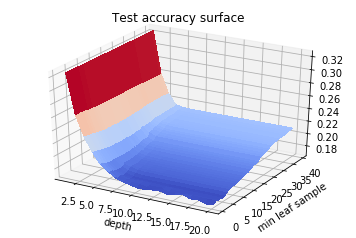

In [32]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(depth_grid, min_samples_leaf_grid, grid_result_test,cmap=cm.coolwarm,linewidth=0, antialiased=False)
plt.title('Test accuracy surface')
plt.xlabel('depth')
plt.ylabel('min leaf sample')
ind = np.unravel_index(np.argmin(grid_result_test, axis=None), grid_result_test.shape)
print('min leaf nb,depth =',ind[0]+1,ind[1]+1,'with error:',grid_result_test[ind])
plt.show()

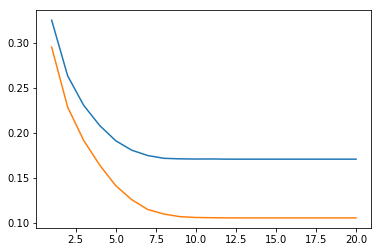

In [35]:
plt.plot(depth_list,grid_result_test[5])
plt.plot(depth_list,grid_result_train[5])
plt.show()

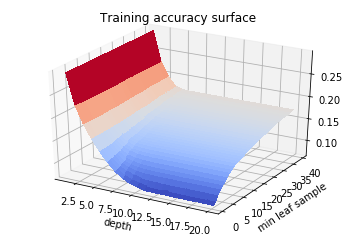

In [38]:
fig = plt.figure()
ax = fig.gca(projection='3d')
plt.title('Training accuracy surface')
plt.xlabel('depth')
plt.ylabel('min leaf sample')
surf = ax.plot_surface(depth_grid, min_samples_leaf_grid, grid_result_train,cmap=cm.coolwarm,linewidth=0, antialiased=False)
plt.show()

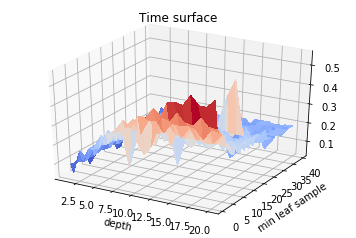

In [39]:
fig = plt.figure()
ax = fig.gca(projection='3d')
plt.title('Time surface')
plt.xlabel('depth')
plt.ylabel('min leaf sample')
surf = ax.plot_surface(depth_grid, min_samples_leaf_grid, time_grid,cmap=cm.coolwarm,linewidth=0, antialiased=False)
plt.show()

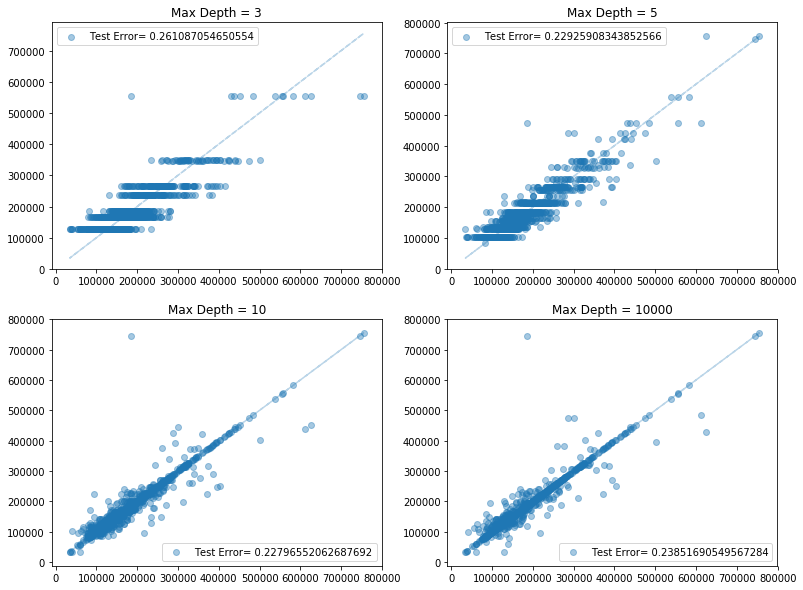

In [66]:
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = test_size, random_state =42)# np.random.randint(0,100))
depths=[3,5,10,10000]
plt.figure(figsize=(13,10))
for i,depth in enumerate(depths):
    plt.subplot(2,2,i+1)
    regressor = DecisionTreeRegressor(max_depth=depth)#min_samples_leaf=13,max_depth=3)
    regressor.fit(X_train, y_train)
    plt.plot(Y,Y,'--',alpha=0.3,label="")
    plt.title("Max Depth = "+str(depth))
    plt.scatter(Y,regressor.predict(X),alpha=0.4,label="Test Error= "+str(getLogRMSE(regressor.predict(X_test),y_test)))
    plt.legend()
    #print(getLogRMSE(regressor.predict(X_test),y_test))
plt.show()

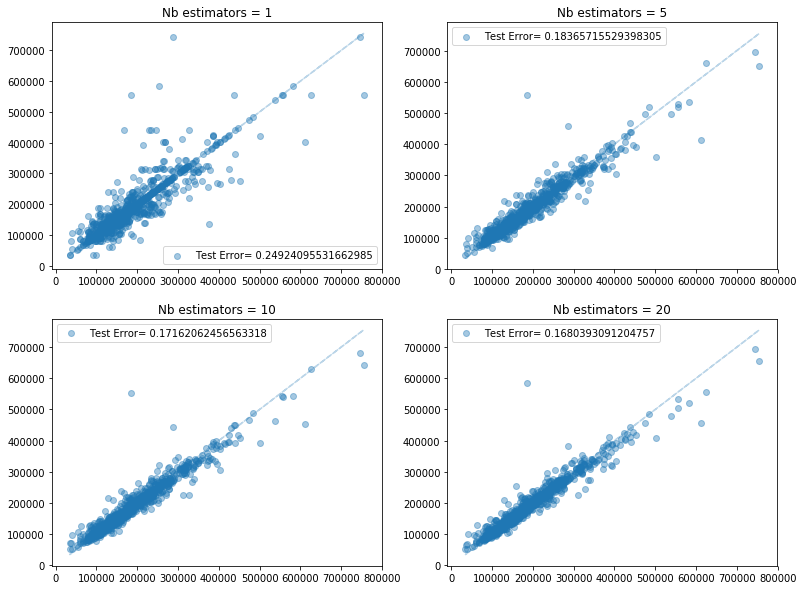

In [68]:
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = test_size, random_state =42)# np.random.randint(0,100))
nb_estimators=[1,5,10,20]
plt.figure(figsize=(13,10))
for i,nb_estimator in enumerate(nb_estimators):
    plt.subplot(2,2,i+1)
    regressor = RandomForestRegressor(n_estimators=nb_estimator,random_state=1234)#, max_depth=depth,min_samples_leaf=min_samples_leaf)
    regressor.fit(X_train, y_train)
    plt.plot(Y,Y,'--',alpha=0.3,label=''),plt.title("Nb estimators = "+str(nb_estimator))
    plt.scatter(Y,regressor.predict(X),alpha=0.4,label="Test Error= "+str(getLogRMSE(regressor.predict(X_test),y_test)))
    plt.legend()
    #print(getLogRMSE(regressor.predict(X_test),y_test))
plt.show()

## PCA

In [37]:
from sklearn.preprocessing import StandardScaler
X_scaled_array = StandardScaler().fit_transform(X)

In [38]:
X_scaled = pd.DataFrame(X_scaled_array,columns=columnNames[1:-1])
X_scaled.head()

,FullBath,LowQualFinSF,Utilities,MSSubClass,YearBuilt,LotFrontage,ExterQual,CentralAir,GarageCars,Alley,...,FireplaceQu,Exterior2nd,Id,BsmtFinType2,BsmtExposure,SaleType,BsmtFinType1,KitchenAbvGr,ExterCond,GarageArea
0,0.068559,-0.037807,-0.097798,-0.198725,0.070888,0.02334,0.760121,0.312249,-0.02888,0.609157,...,-0.273646,-0.057619,0.054253,0.451774,-0.195673,-0.083907,-1.613654,0.143474,0.321483,0.214464
1,-0.868995,-0.037807,0.484720,-0.090385,0.070888,0.02334,0.760121,0.312249,-0.02888,-0.614255,...,-0.273646,-0.057619,0.054253,0.451774,-0.195673,-0.083907,-0.490895,-0.614977,0.321483,0.214464
2,0.068559,-0.037807,0.018705,0.065060,0.070888,0.02334,-1.362793,0.312249,-0.02888,0.609157,...,-0.273646,-0.057619,0.054253,0.451774,-0.195673,-0.083907,1.006117,0.143474,0.321483,0.214464
3,0.302947,-0.037807,-0.291971,-0.095096,0.070888,0.02334,-1.362793,0.312249,-0.02888,-1.837666,...,-0.273646,-0.057619,0.054253,0.451774,-0.195673,-0.083907,-1.613654,-1.373428,0.321483,-3.372392
4,0.068559,-0.037807,0.640059,0.348628,0.070888,0.02334,-1.362793,0.312249,-0.02888,-0.614255,...,-0.273646,-0.057619,0.054253,0.451774,-0.195673,-0.083907,2.128875,0.143474,0.321483,0.214464


In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X_scaled)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])

In [40]:
finalDf = pd.concat([principalDf, Y], axis = 1)
finalDf.head()

,pc1,pc2,SalePrice
0,2.330400,0.627373,208500
1,0.199639,-2.273799,181500
2,2.756014,0.278293,223500
3,-1.448721,1.045794,140000
4,5.006458,0.872887,250000


In [46]:
plt.figure(figsize=(15,8))
hist = plt.hist(finalDf.SalePrice,cumulative=True,normed=True,bins='auto')
for c, p in zip(hist[0], hist[2]):
    plt.setp(p, 'facecolor', cmap(c))
plt.clf()
plt.close()

In [47]:
def normHist(row):
    salePrice = row.SalePrice
    index = [i for i,x in enumerate(hist[1]) if x<=salePrice][-1]
    #print(index,salePrice)
    return hist[0][index-1]
colors = finalDf.apply(normHist,axis=1)
colors.head()

0    0.727500
1    0.575833
2    0.778333
3    0.238333
4    0.820833
dtype: float64

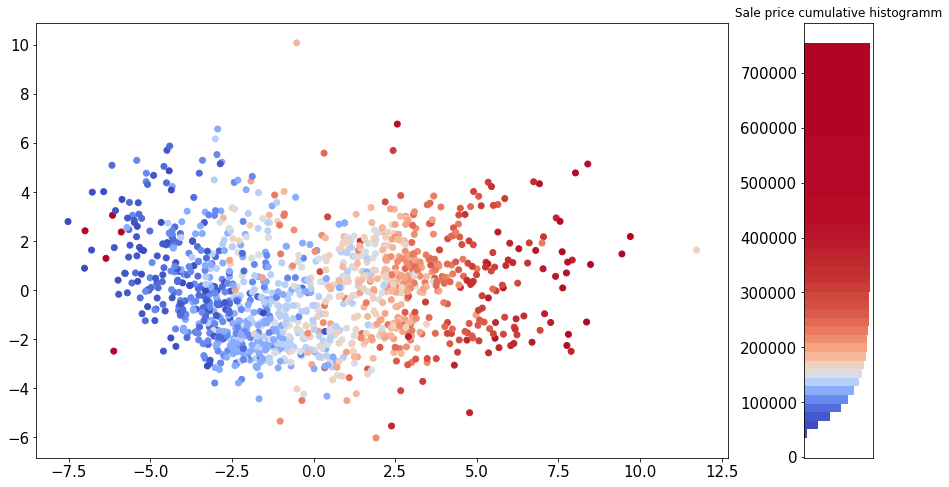

In [48]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(15,8))
gs = gridspec.GridSpec(1, 2, width_ratios=[10, 1])
plt.subplot(gs[0])
sc = plt.scatter(finalDf.pc1,finalDf.pc2,c=colors,cmap=cmap)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
#plt.colorbar(sc,ticks=finalDf.SalePrice)
plt.subplot(gs[1])
histbis = plt.hist(finalDf.SalePrice,cumulative=True,normed=True,bins='auto',orientation='horizontal')
for c, p in zip(histbis[0], histbis[2]):
    plt.setp(p, 'facecolor', cmap(c))
plt.gca().set_xscale("log")
plt.title("Sale price cumulative histogramm")
plt.yticks(fontsize=15)
plt.tick_params(axis='x',which='both',bottom='off',labelbottom='off')
plt.show()

### Improvement
* PCA
* Scaling -> mean=0 + var = 1  for data
* Stats
* Boosting

# Goal of the challenge

It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable.

## Metric
Notebooks are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

## Submission File Format
The file should contain a header and have the following format:

```
Id,SalePrice
1461,169000.1
1462,187724.1233
1463,175221
etc.
```

You will find an example submission file within the data directory in the repository.

# Grading the notebook

This challenge is going to be graded as a regular notebook for the AML labs. As a consequence, students should submit:

* the html version of the notebook, using the Data Science Labs submission website, as usual [**Assignement: Challenge Notebook**]
* the submission file (in csv format), that we will use to rank students according to the metric defined above, again through the Data Science Labs submission website [**Assignement: Challenge Predictions**]

In summary, you will have to submit 2 files!

In [56]:
!ls

README.md		challenge_data	      temp		     tree.png
Scikitlearn_Tree.ipynb	challenge_home.ipynb  testParseSchema.ipynb
challenge.ipynb		spark-warehouse       tree.dot
